# Analisi Fianziaria di Criptovalute

# 0. Analisi del Mercato

# 1. Estrazione dei Dati
I dati sono stati estratti dal sito *Yahoo Finance* usando delle REST API. I dati sono stati scaricati per tre criptovalute: <br>
* Ethereum <br>
* Bitcoin <br>
* Binance <br>

I dati sono stati scaricati per l'intervallo temporale tra *2018-01-01* e *2023-10-01* <br>

In [56]:
import DataExtractor

cryptoList : list[str] = ["ETH-USD", "BTC-USD", "DASH-USD", "XRP-USD"]

startDate : str = "2018-01-01"
endDate : str = "2023-10-01"
interval : str = "daily"

for crypto in cryptoList :
    DataExtractor.extractData(crypto, startDate, endDate, interval)

In [57]:
import os, pandas as pd

In [58]:
cryptoDataFrameDict : dict[str, pd.DataFrame] = {}
for crypto in cryptoList :
    inputFileName : str = crypto + "_Data.csv"
    inputFilePath = os.path.join("./", "data", inputFileName)
    dataFrame : pd.DataFrame = pd.read_csv(filepath_or_buffer = inputFilePath)
    cryptoDataFrameDict[crypto] = dataFrame 

## 2. Analisi del Dataset

### 2_1. Passaggio al Logaritmo

In [59]:
import numpy as np

In [60]:
def logConvertion(dataFrame : pd.DataFrame, columnName : str) :
    dataFrame["LogClosePrice"] = np.log10(dataFrame[columnName])

In [61]:
for crypto in cryptoList :
    cryptoDf : pd.DataFrame = cryptoDataFrameDict[crypto]
    logConvertion(cryptoDf, "Close")

cryptoDataFrameDict["ETH-USD"]["LogClosePrice"]

0       2.887978
1       2.946670
2       2.983500
3       2.991634
4       2.999009
          ...   
2095    3.203438
2096    3.218242
2097    3.222181
2098    3.223019
2099    3.239002
Name: LogClosePrice, Length: 2100, dtype: float64

In [62]:
import matplotlib.pyplot as plt

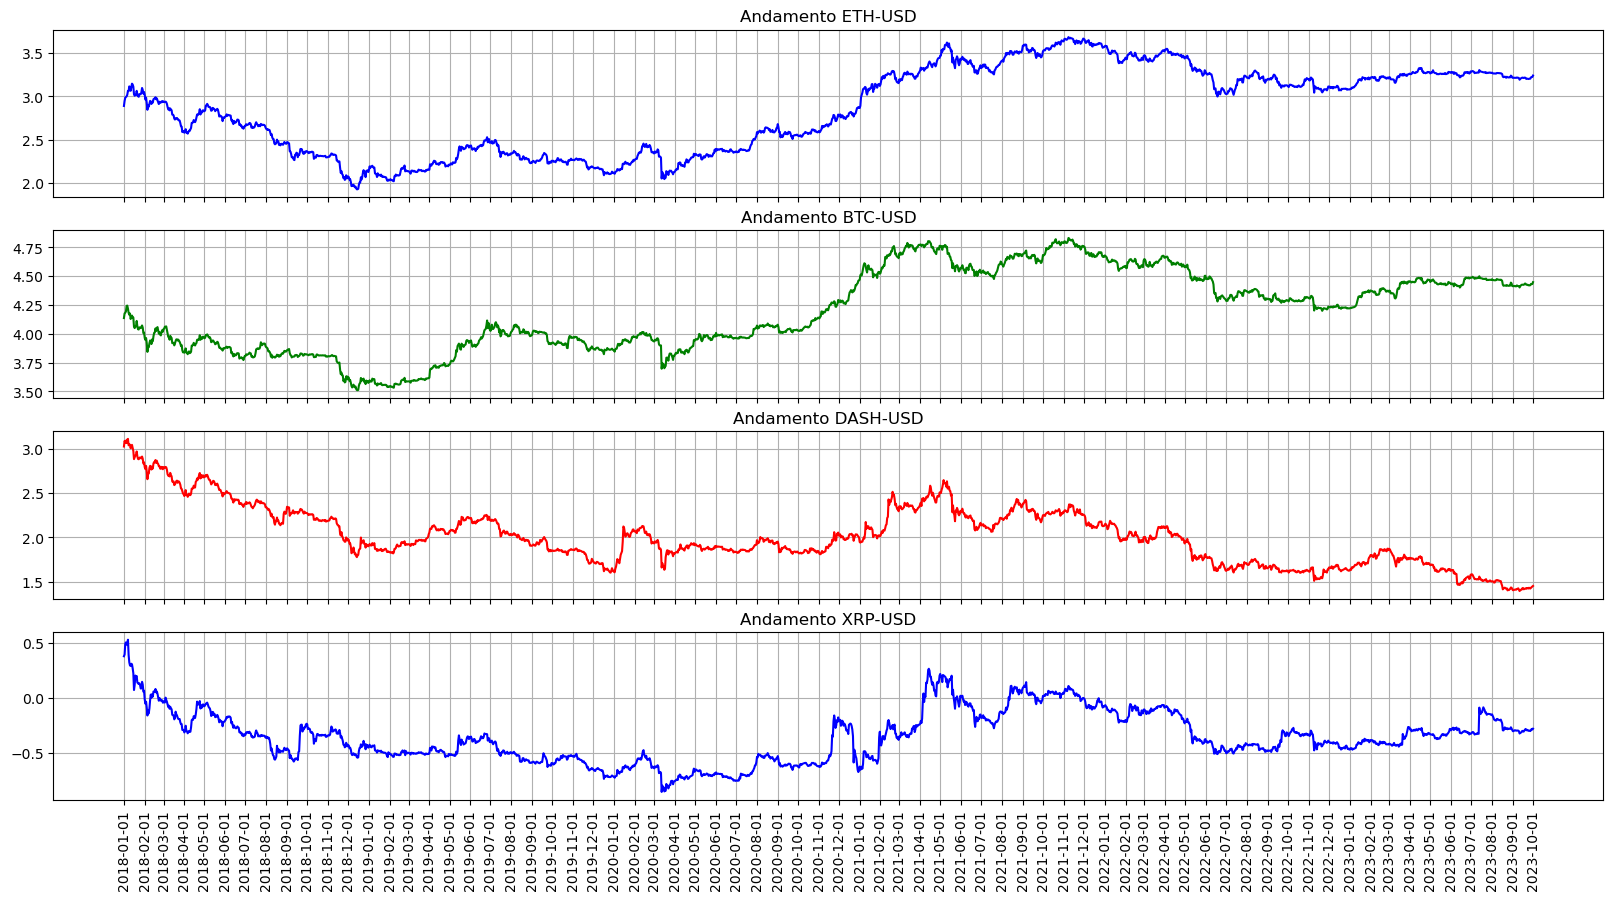

<Figure size 640x480 with 0 Axes>

In [63]:
colors = ["blue", "green", "red"]
figure, axs = plt.subplots(nrows = len(cryptoList), sharex = True, figsize = (20,10))

xtickPoints = cryptoDataFrameDict["ETH-USD"]["Date"]
xtickPoints = xtickPoints[xtickPoints.str.endswith("01") == 1]
i = 0 
for crypto in cryptoList :
    axs[i].plot(cryptoDataFrameDict[crypto]["LogClosePrice"], color = colors[i % len(colors)])
    axs[i].set_title("Andamento " + crypto)
    axs[i].grid(True)
    i += 1

axs[len(cryptoList) - 1].set_xticks(xtickPoints.index)
axs[len(cryptoList) - 1].set_xticklabels(xtickPoints.values, rotation = 90)

plt.show()
plt.clf()

### 2_2. Ricerca di una componenti di Random Walk
Le componenti di Random Walk vengono ricercate usando due Test di Ipotesi:
* Adfuller
* KPSS

Nel test di KPSS abbiamo:
* $H_0$ : La serie è stazionaria attorno a una tendenza deterministica (NON ha componente di Random Walk)
* $H_1$ : La serie non è stazionaria (HA componente di Random Walk)

Nel test di Adfuller abbiamo:
* $H_0$ : La serie ha una radice unitaria (HA componente di Random Walk)
* $H_1$ : La serie non ha una radice unitaria (NON ha componente di Random Walk)

Nel nostro caso vogliamo:
* KPSS, **Rigettare**
* Adfuller, **Accettare**

In [64]:
from rich.console import Console
from rich.table import Table

In [65]:
def buildTable(testName : str, headerList : list[str], justifyList: list[str]) -> Table :
    table = Table(title = "Test " + testName)
    for i in range(0, len(headerList)) :
        table.add_column(headerList[i], justify = justifyList[i])
    return table

In [66]:
from statsmodels.tsa.stattools import adfuller, kpss

In [67]:
%%capture --no-display

SIGNIFICANCE_LEVEL = 0.05

kpssTable : Table = buildTable("KPSS", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    kpssStat, pValue, _, _ = kpss(cryptoDataFrameDict[crypto]["LogClosePrice"])
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    kpssTable.add_row(crypto, str(kpssStat), str(pValue), outcomeString)
console = Console()
console.print(kpssTable)

adfullerTable = buildTable("Adfuller", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    result = adfuller(cryptoDataFrameDict[crypto]["LogClosePrice"])
    adfullerStat : float = result[0]
    pValue = result[1]
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    adfullerTable.add_row(crypto, str(adfullerStat), str(pValue), outcomeString)
console = Console()
console.print(adfullerTable)

                     Test KPSS                      
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 4.6868634079376505 │   0.01 │ Reject  │
│ BTC-USD  │  4.852563872844437 │   0.01 │ Reject  │
│ DASH-USD │ 2.8786921714522227 │   0.01 │ Reject  │
│ XRP-USD  │ 0.9379861415751735 │   0.01 │ Reject  │
└──────────┴────────────────────┴────────┴─────────┘

                           Test Adfuller                           
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃               pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ -0.9316698059416457 │   0.7773643024779462 │ Accept  │
│ BTC-USD  │ -0.9795375977486944 │   0.7606541432486267 │ Accept  │
│ DASH-USD │  -2.881850211028939 │  0.04749964548210756 │ Reject  │
│ XRP-USD  │  -3.484573241606299 │ 0.008392238318212005 │ Reject  │
└──────────┴─────────────────────┴──────────────────────┴─────────┘

### 2_3. Differencing della serie storica e analisi del rumore
Procediamo lo studio con l'analisi del rumore.

Passiamo al differencing della serie storica, ottenendo $Y_{t+1} - Y_{t} = W_{t}$ e procedendo con un'analisi del termine $W_{t}$.

Il differencing viene fatto sul risultato del passaggio al logaritmo dei valori originari. Siano:
* *Y*, valori logaritmici
* *P*, valori originari
* *R*, rendimento

Fare il differencing dei valori logaritmici ci permette di fare quanto segue:

$Y_{t+1} - Y_{t} = \log(P_{t+1}) - \log(P_t) = \log(\frac{P_{t+1}}{P_{t}}) = \log(R) = W_t$

Ovvero analizzare se il rendimento ha o meno natura di rumore bianco

In [68]:
differencingDict : dict[str, pd.Series] = {}
for crypto in cryptoDataFrameDict :
    logPriceSeries : pd.Series = cryptoDataFrameDict[crypto]["LogClosePrice"]
    differencing : pd.Series = logPriceSeries.diff()
    differencing.dropna(inplace = True)
    differencing.reset_index(inplace = True, drop = True)
    differencingDict[crypto] = differencing

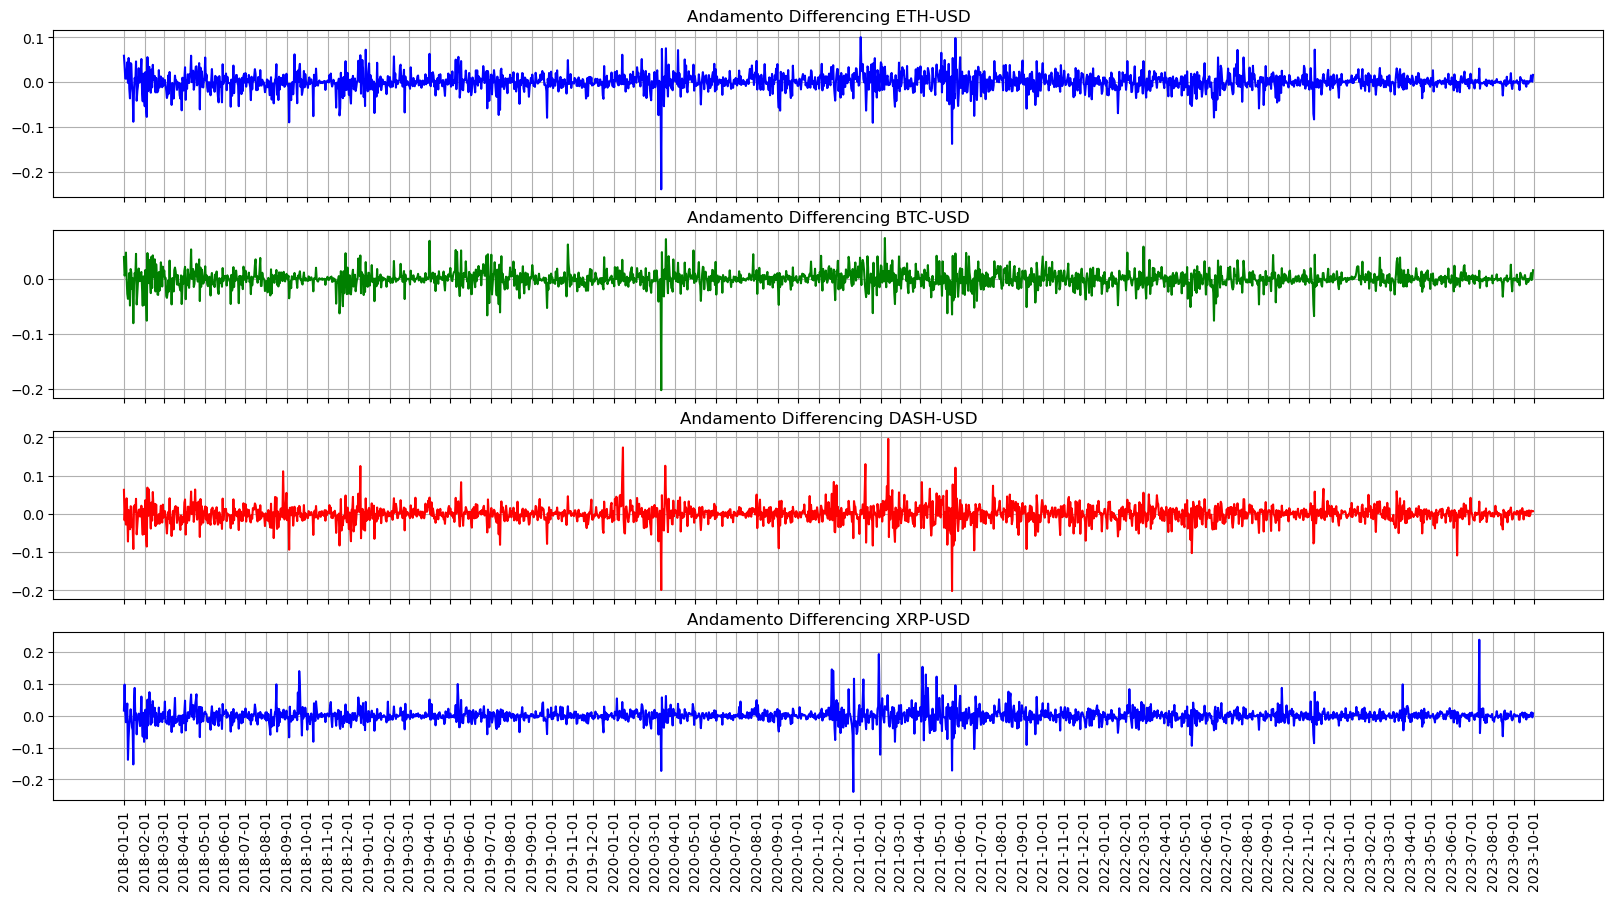

<Figure size 640x480 with 0 Axes>

In [69]:
colors = ["blue", "green", "red"]
figure, axs = plt.subplots(nrows = len(cryptoList), sharex = True, figsize = (20,10))

xtickPoints = cryptoDataFrameDict["ETH-USD"]["Date"]
xtickPoints = xtickPoints[xtickPoints.str.endswith("01") == 1]
i = 0 
for crypto in cryptoList :
    axs[i].plot(differencingDict[crypto], color = colors[i % len(colors)])
    axs[i].set_title("Andamento Differencing " + crypto)
    axs[i].grid(True)
    i += 1

axs[len(cryptoList) - 1].set_xticks(xtickPoints.index)
axs[len(cryptoList) - 1].set_xticklabels(xtickPoints.values, rotation = 90)

plt.show()
plt.clf()

### Analisi Stazionarietà
Per l'analisi di stazionarietà eseguiamo due test:
* KDSS
* Adfuller

Nel test di KPSS abbiamo:
* *H0* : La serie è stazionaria attorno a una tendenza deterministica
* *H1* : La serie non è stazionaria

Nel test di Adfuller abbiamo:
* *H0* : La serie ha una radice unitaria
* *H1* : La serie non ha una radice unitaria

Nel nostro caso vogliamo:
* KPSS, **Accettare**
* Adfuller, **Rigettare**

In [70]:
%%capture --no-display

SIGNIFICANCE_LEVEL = 0.05

kpssTable : Table = buildTable("KPSS", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    kpssStat, pValue, _, _ = kpss(differencingDict[crypto])
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    kpssTable.add_row(crypto, str(kpssStat), str(pValue), outcomeString)
console = Console()
console.print(kpssTable)

adfullerTable = buildTable("Adfuller", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList :
    result = adfuller(differencingDict[crypto])
    adfullerStat : float = result[0]
    pValue = result[1]
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    adfullerTable.add_row(crypto, str(adfullerStat), str(pValue), outcomeString)
console = Console()
console.print(adfullerTable)

                      Test KPSS                      
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 0.23232100911103254 │    0.1 │ Accept  │
│ BTC-USD  │ 0.15692126442528623 │    0.1 │ Accept  │
│ DASH-USD │  0.1410478256477686 │    0.1 │ Accept  │
│ XRP-USD  │ 0.20362713282803369 │    0.1 │ Accept  │
└──────────┴─────────────────────┴────────┴─────────┘

                           Test Adfuller                            
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃                pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ -13.790666010400082 │ 8.938903049210615e-26 │ Reject  │
│ BTC-USD  │ -16.054673615817418 │ 5.724496998603609e-29 │ Reject  │
│ DASH-USD │  -21.84555549991941 │                   0.0 │ Reject  │
│ XRP-USD  │  -47.09379297354783 │                   0.0 │ Reject  │
└──────────┴─────────────────────┴───────────────────────┴─────────┘

Dal test di KPSS e dal test ADF, possiamo concludere che il differencing $W_t$ è stazionario

### Analisi Eteroschedasticità
Per l'analisi di eteroschedasticità eseguiamo i seguenti test:
* Breusch-Pagan
* White

Nel test di Breusch-Pagan abbiamo:
* $H_0$: I residui sono distribuiti con varianza omogenea (La serie è Omoschedastica)
* $H_1$: I residui *NON* sono distribuiti con varianza omogenea (La serie *NON* è omoschedastica)

Nel test di White abbiamo:
* $H_0$: La varianza dei residui è costante (La serie è Omoschedastica)
* $H_1$: La varianza dei residui *NON* è costante (La serie *NON* è Omoschedastica)

In questo caso vogliamo:
* Breusch-Pagan, **Accettare**
* White, **Accettare**

In [71]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from scipy.stats import kurtosis

In [72]:
# Crea il modello
SIGNIFICANCE_LEVEL = 0.05
bpTable = buildTable("Breusch-Pagan", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
whiteTable = buildTable("White", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])

for crypto in cryptoList :
    x = sm.add_constant(differencingDict[crypto].index.tolist())
    model = sm.OLS(differencingDict[crypto].values, x)
    fittedModel = model.fit()
    print(crypto)
    print(fittedModel.summary())
    residKurtosis = kurtosis(fittedModel.resid)

    # In the general description of LM test, Greene mentions that this test exaggerates the significance of results in small or moderately large samples. 
    # In this case the F-statistic is preferable.

    # BREUSCH-PAGAN TEST
    lmValue, lm_pvalue, fValue, f_pvalue = het_breuschpagan(fittedModel.resid, fittedModel.model.exog, not (residKurtosis > 0.05))
    statValue, pValue = fValue, f_pvalue
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    bpTable.add_row(crypto, str(statValue), str(pValue), outcomeString)
    # WHITE TEST
    lmValue, lm_pvalue, fValue, f_pvalue = het_white(fittedModel.resid, fittedModel.model.exog)
    statValue, pValue = fValue, f_pvalue
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    whiteTable.add_row(crypto, str(statValue), str(pValue), outcomeString)

ETH-USD
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6008
Date:                Thu, 09 Nov 2023   Prob (F-statistic):              0.438
Time:                        12:18:47   Log-Likelihood:                 5137.8
No. Observations:                2099   AIC:                        -1.027e+04
Df Residuals:                    2097   BIC:                        -1.026e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.488 

In [73]:
console = Console()
console.print(bpTable)
console.print(whiteTable)

                        Test Breusch-Pagan                         
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  10.09401635446327 │  0.001509158287730649 │ Reject  │
│ BTC-USD  │  9.034449223320047 │ 0.0026808145430633193 │ Reject  │
│ DASH-USD │  3.170354214671846 │   0.07513092166524234 │ Accept  │
│ XRP-USD  │ 1.8262101201746168 │   0.17672160857021277 │ Accept  │
└──────────┴────────────────────┴───────────────────────┴─────────┘

                            Test White                            
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃               pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │  6.254042748502992 │ 0.001958736118373128 │ Reject  │
│ BTC-USD  │  4.888897866960857 │ 0.007615802570627914 │ Reject  │
│ DASH-USD │  4.632834242748941 │  0.00982697358612899 │ Reject  │
│ XRP-USD  │ 1.1894641460962103 │  0.30458970287057635 │ Accept  │
└──────────┴────────────────────┴──────────────────────┴─────────┘

### Analisi Autocorrelazione

Per l'Autocorrelazione consideriamo i seguenti test:
* Ljung-Box
* Durbin-Watson

Consideriamo in particolare l'autocorrelazione del primo ordine, ovvero analizziamo l'eventuale autocorrelazione di due residui successivi.

Per il test Ljung-Box:
* $H_0$: Non c'è autocorrelazione nei dati. In altre parole, i residui sono indipendenti l'uno dall'altro e non mostrano alcuna struttura di autocorrelazione significativa.
* $H_1$: I residui non sono indipendenti e mostrano una struttura di autocorrelazione significativa.

Per il test Durbin-Watson:
* $H_0$: Non c'è autocorrelazione di primo ordine nei residui del modello. In altre parole, l'autocorrelazione tra i residui ad uno e due intervalli di tempo di distanza è zero.
* $H_1$: C'è autocorrelazione di primo ordine nei residui del modello. I residui consecutivi sono correlati in qualche modo.

Vogliamo quindi :
* Ljung-Box, **Accettare**
* Durbin-Watson, **Accettare**

In [74]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [96]:
model = sm.tsa.ARIMA(cryptoDataFrameDict["ETH-USD"]["LogClosePrice"])
fittedModel = model.fit()
testResult = acorr_ljungbox(fittedModel.resid, lags = 50)
print(testResult["lb_pvalue"])

x = sm.add_constant(differencingDict[crypto].index.tolist())
model = sm.OLS(differencingDict["ETH-USD"].values, x)
fittedModel = model.fit()
print(durbin_watson(fittedModel.resid))

1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
34    0.0
35    0.0
36    0.0
37    0.0
38    0.0
39    0.0
40    0.0
41    0.0
42    0.0
43    0.0
44    0.0
45    0.0
46    0.0
47    0.0
48    0.0
49    0.0
50    0.0
Name: lb_pvalue, dtype: float64
2.1023462596198113


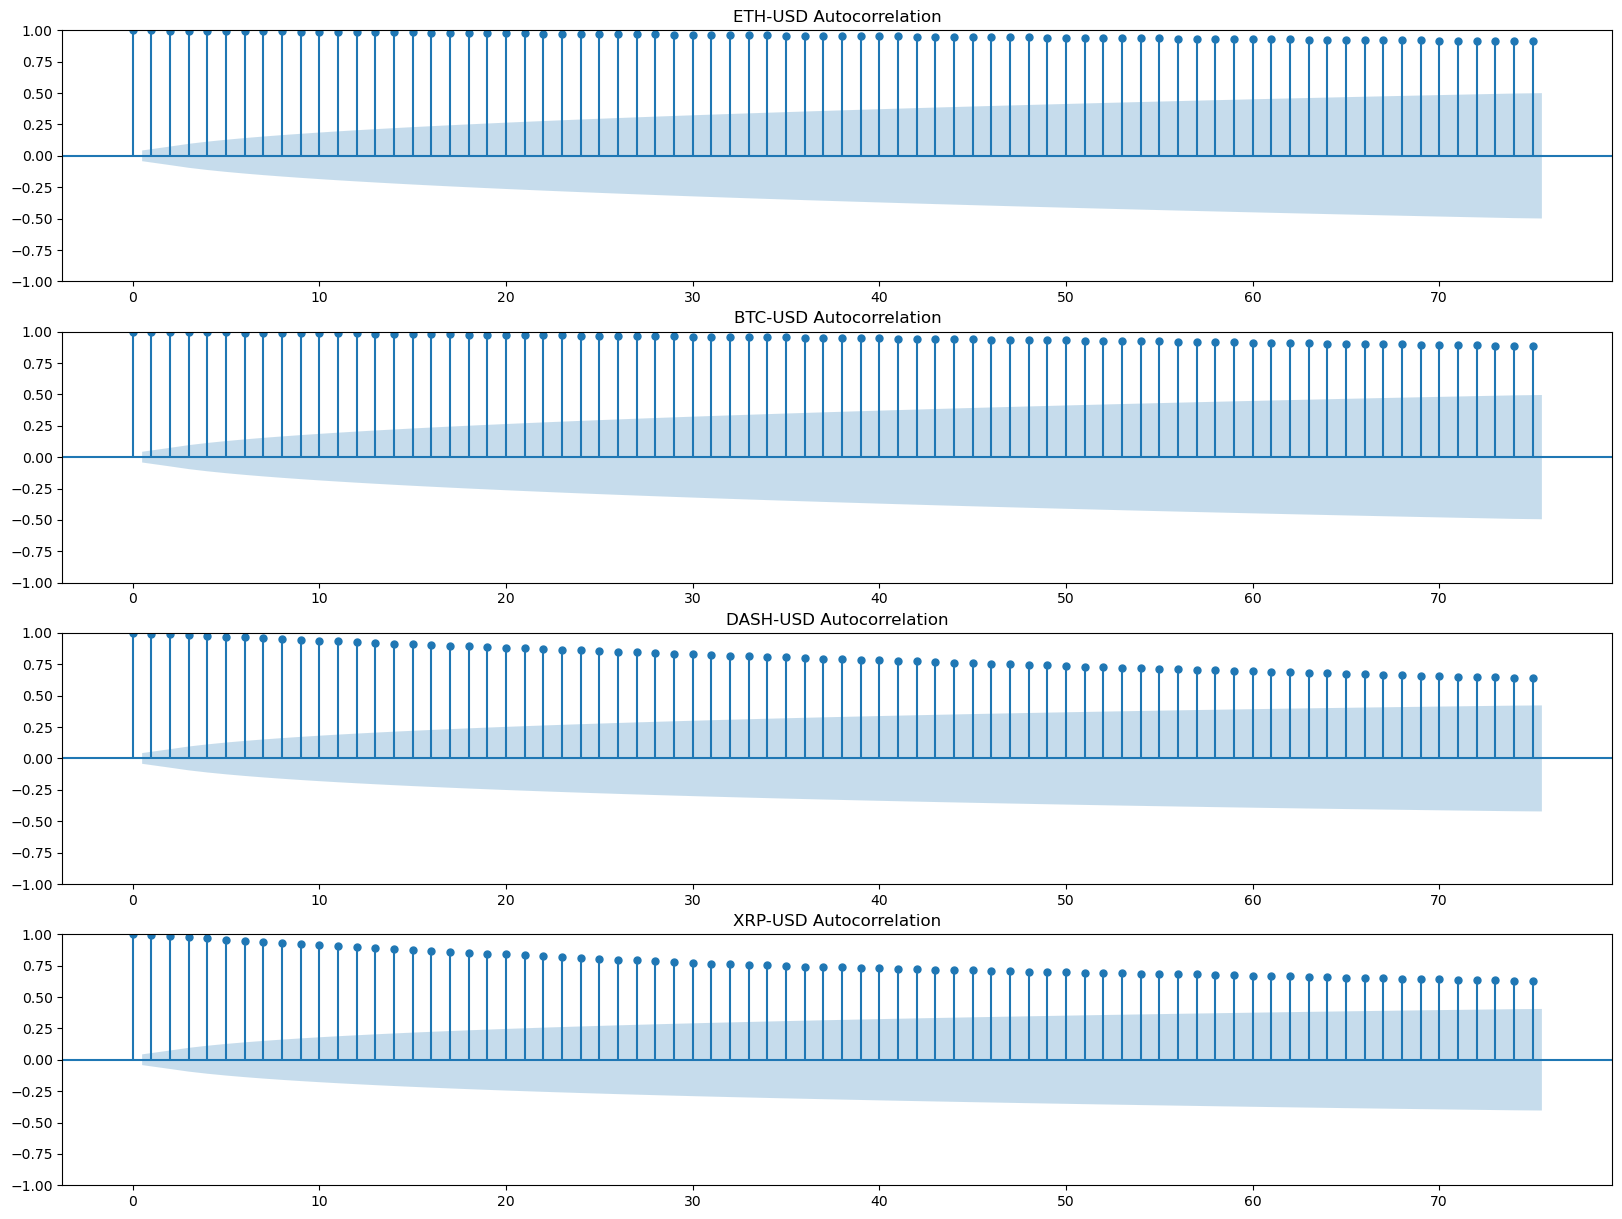

<Figure size 640x480 with 0 Axes>

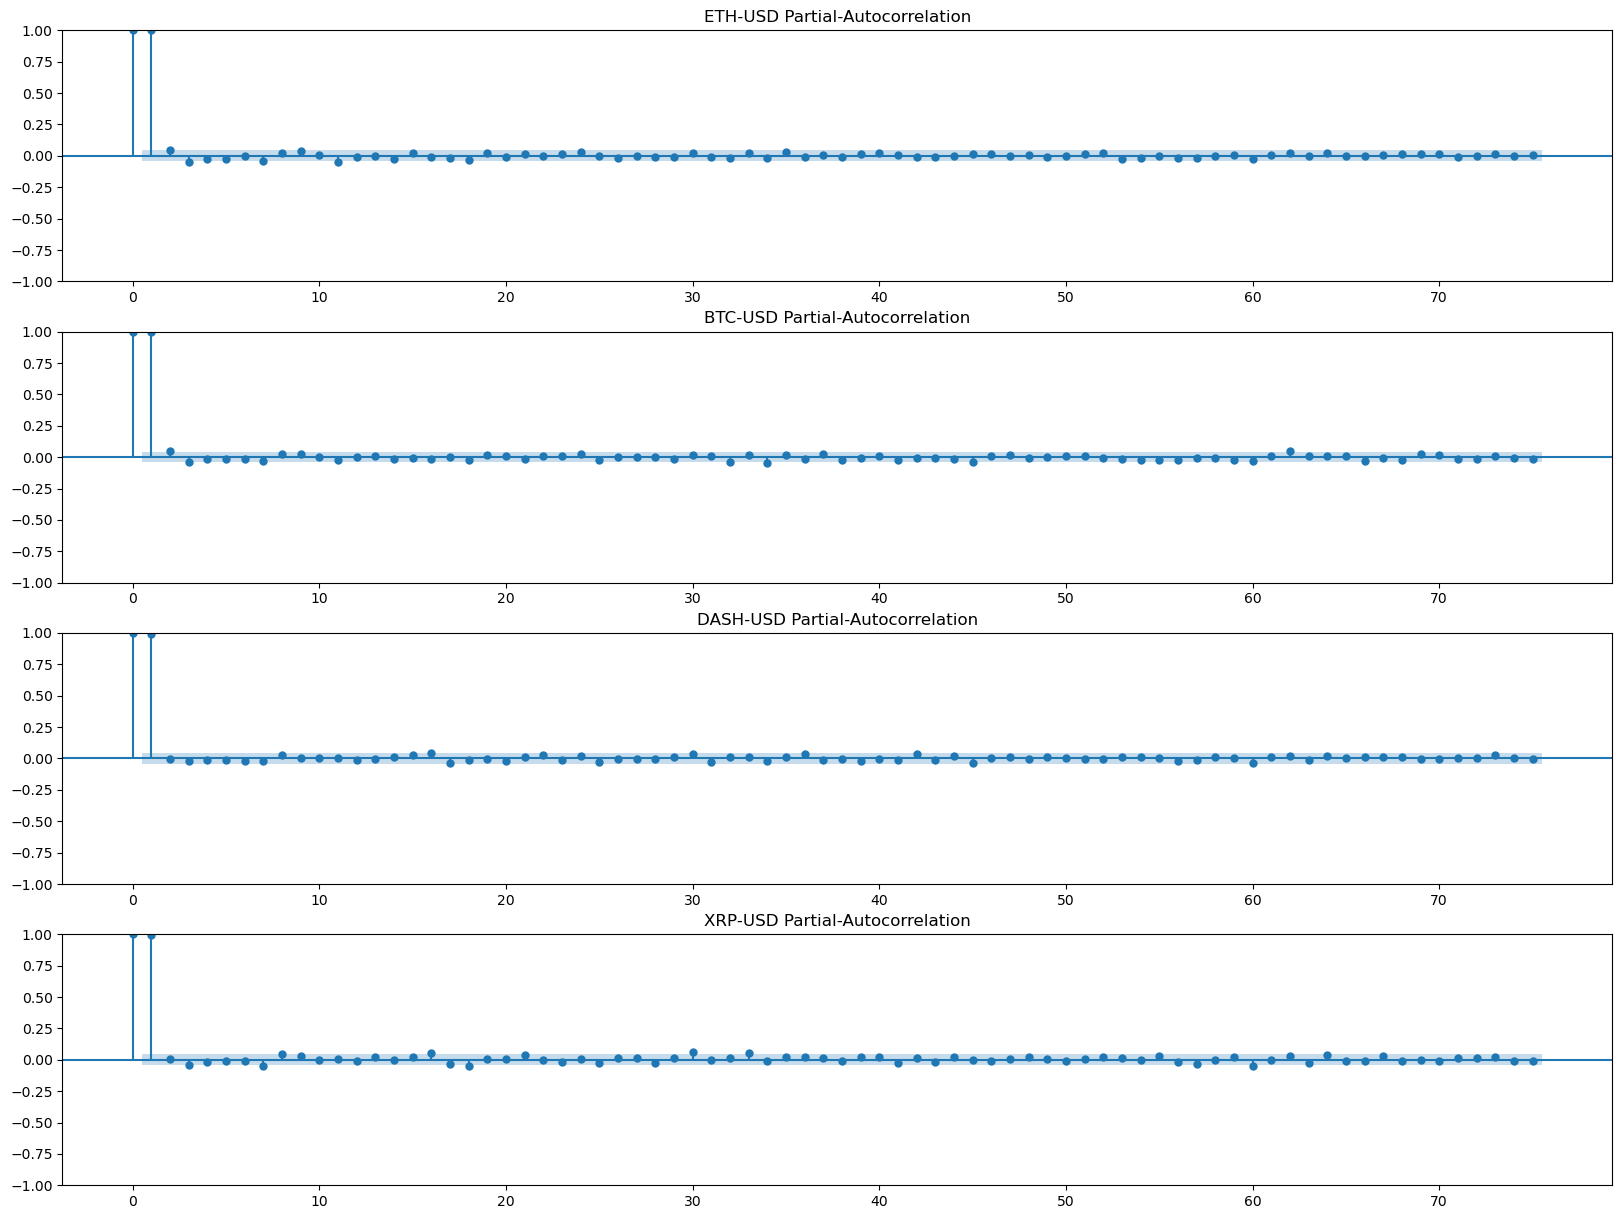

<Figure size 640x480 with 0 Axes>

In [123]:
# Use the Autocorrelation function from the statsmodel library passing our DataFrame object in as the data
# Note: Limiting Lags to 50
fig, ax = plt.subplots(figsize=(20, 15), nrows = len(cryptoList), ncols = 1)
i = 0 
for crypto in cryptoList :
    plot_acf(x = cryptoDataFrameDict[crypto]["LogClosePrice"], ax = ax[i], lags = 75, title = crypto + " Autocorrelation")
    i += 1
plt.show()
plt.clf()

fig, ax = plt.subplots(figsize=(20, 15), nrows = len(cryptoList), ncols = 1)
i = 0 
for crypto in cryptoList :
    plot_pacf(x = cryptoDataFrameDict[crypto]["LogClosePrice"], ax = ax[i], lags = 75, title = crypto + " Partial-Autocorrelation")
    i += 1
plt.show()
plt.clf()

### Analisi Normalità
Per l'analisi di normalità eseguiamo i seguenti test:
* Shapiro-Wilk
* Kolmogorov-Smirnov

Nel test di Shapiro-Wilk abbiamo:
* *H0*: I dati seguono una distribuzione normale
* *H1*: I dati NON seguono una distribuzione normale

Nel test di Kolmogorov-Smirnov abbiamo:
* *H0*: I dati seguono la distribuzione specificata
* *H1*: I dati NON seguono la distribuzione specificata

Nel nostro caso vogliamo:
* Shapiro-Wilk, **Accettare**
* Kolmogorov-Smirnov, **Accettare**

In [77]:
#%%capture --no-display

from scipy.stats import shapiro, kstest, norm

SIGNIFICANCE_LEVEL = 0.05

# Esegue il test di normalità di Shapiro-Wilk
shapiroTable = buildTable("Shapiro-Wilk", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList:   
    statValue, pValue = shapiro(differencingDict[crypto])
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    shapiroTable.add_row(crypto, str(statValue), str(pValue), outcomeString)
console = Console()
console.print(shapiroTable)

ksTable = buildTable("Kolmogorov-Smirnov", ["Crypto", "StatValue", "pValue", "Outcome"], ["left", "right", "right", "left"])
for crypto in cryptoList:   
    statValue, pValue = kstest(differencingDict[crypto], norm.cdf)
    outcomeString = "Reject" if pValue < SIGNIFICANCE_LEVEL else "Accept"
    ksTable.add_row(crypto, str(statValue), str(pValue), outcomeString)
console = Console()
console.print(ksTable)


                         Test Shapiro-Wilk                          
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃          StatValue ┃                 pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 0.9206165671348572 │  6.886141709906552e-32 │ Reject  │
│ BTC-USD  │ 0.9050827026367188 │ 2.9094350732402905e-34 │ Reject  │
│ DASH-USD │ 0.9020655155181885 │  1.093689127554672e-34 │ Reject  │
│ XRP-USD  │ 0.8333722352981567 │ 2.5293437281062948e-42 │ Reject  │
└──────────┴────────────────────┴────────────────────────┴─────────┘

               Test Kolmogorov-Smirnov               
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓
┃ Crypto   ┃           StatValue ┃ pValue ┃ Outcome ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩
│ ETH-USD  │ 0.47060699747365353 │    0.0 │ Reject  │
│ BTC-USD  │ 0.47612228682032764 │    0.0 │ Reject  │
│ DASH-USD │  0.4662001485725673 │    0.0 │ Reject  │
│ XRP-USD  │ 0.46432731015676304 │    0.0 │ Reject  │
└──────────┴─────────────────────┴────────┴─────────┘

Notiamo quindi che i due test ci fanno rigettare in entrambi i casi l'ipotesi nulla di normalità dei dati.
Per completezza tracciamo un grafico dei dati.

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   3.,   1.,   8.,
          4.,  12.,  13.,  11.,  34.,  61.,  77., 160., 291., 494., 386.,
        224., 136.,  74.,  45.,  29.,  14.,  10.,   2.,   6.,   0.,   0.,
          2.]),
 array([-0.23917976, -0.23163821, -0.22409667, -0.21655513, -0.20901359,
        -0.20147204, -0.1939305 , -0.18638896, -0.17884742, -0.17130587,
        -0.16376433, -0.15622279, -0.14868124, -0.1411397 , -0.13359816,
        -0.12605662, -0.11851507, -0.11097353, -0.10343199, -0.09589045,
        -0.0883489 , -0.08080736, -0.07326582, -0.06572427, -0.05818273,
        -0.05064119, -0.04309965, -0.0355581 , -0.02801656, -0.02047502,
        -0.01293348, -0.00539193,  0.00214961,  0.00969115,  0.01723269,
         0.02477424,  0.03231578,  0.03985732,  0.04739887,  0.05494041,
         0.06248195,  0.07002349,  0.07756504,  0.08510658,  0.09264812,
         0.10018966]),
 <BarCon

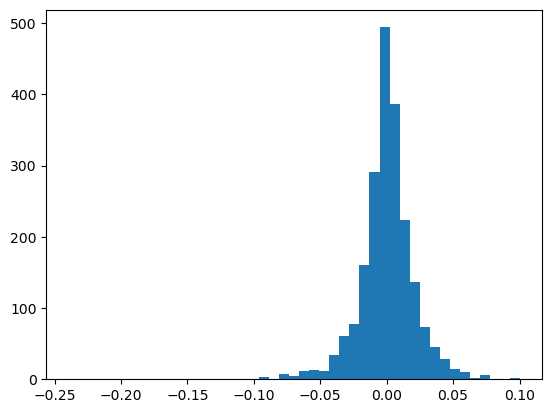

In [78]:
binsNum = int(np.sqrt(len(differencingDict["ETH-USD"])))
plt.hist(x = differencingDict["ETH-USD"], bins = binsNum, histtype = "bar")